In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.preprocessing import RobustScaler
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
isee_machine = pd.read_csv('./data/isee_machine_middel_NG_enc.csv')

In [5]:
isee_machine.shape, isee_machine.columns

((183201, 30),
 Index(['ModuleCount', 'creationTime', 'CycleTime', 'VpPosition', 'VpTime',
        'VpPressure', 'MaxInjectionPressure', 'InjectionEndPosition',
        'PlasticizingTime', 'PlasticsEndPosotion', 'ClampingTime',
        'MouldOpeningTime', 'HotOilContoller', 'TankTemp', 'NozzleTemp',
        'Zone1', 'Zone2', 'Zone3', 'Zone4', 'creationDate', 'creationHour',
        'YM', 'creationTime_diff', 'CycleNum', 'Operation_label',
        'Qua_Match_YN', 'NG', 'NG5', 'encoding', 'ProductNum'],
       dtype='object'))

In [6]:
prod_list = isee_machine.ProductNum.unique()

In [7]:
isee_machine = isee_machine[isee_machine.ProductNum == prod_list[0]]

In [8]:
analy_col = ['CycleTime', 'VpPosition', 'VpTime',
        'VpPressure', 'MaxInjectionPressure', 'InjectionEndPosition',
        'PlasticizingTime', 'PlasticsEndPosotion', 'ClampingTime',
        'MouldOpeningTime', 'HotOilContoller', 'TankTemp', 'NozzleTemp',
        'Zone1', 'Zone2', 'Zone3', 'Zone4'] 

### ① Widnow_size, stride_size 방법

In [6]:
win_size = 10
str_size = 3
temp_df = pd.DataFrame(columns=analy_col)
ma_df = pd.DataFrame(columns=analy_col+['CycleNum'])

cycle_list = np.unique(isee_machine['CycleNum'])
for cy in cycle_list[:10]: 
    df = isee_machine[isee_machine['CycleNum']==cy]
    df = df.reset_index(drop=True)
    iter = np.ceil((df.shape[0] - win_size)/str_size).astype(int)
    for i in range(iter):
        a_df = pd.DataFrame(df[analy_col].loc[str_size*i:(win_size-1) + str_size*i].sum()/win_size)
        temp_df = pd.concat([temp_df,a_df.T], axis=0, sort=False)
    temp_df['CycleNum'] = cy
    ma_df = pd.concat([ma_df, temp_df], axis=0, sort=False)

In [26]:
ma_df['NG_Label'] = [1 if x >0.7 else 0 for x in ma_df['NG5']]
ma_df = ma_df.reset_index(drop=True)

In [27]:
ma_df.shape

(24379, 20)

### ② 벡터 계산 방법

In [9]:
cycle_list = np.unique(isee_machine['CycleNum'])
vec_df = pd.DataFrame(columns=analy_col+['CycleNum','NG'])
before_n = 10 # n개 전 vector

for cy in cycle_list[:10]:    
    df = isee_machine[isee_machine['CycleNum']==cy]
    df = df.reset_index(drop=True)
    for i in range(before_n,len(df)):
        #t1 = (df[analy_col].loc[i]-df[analy_col].loc[i-1]) * 3
        #t5 = (df[analy_col].loc[i]-df[analy_col].loc[i-5]) / 5 * 3 
        t10 = (df[analy_col].loc[i]-df[analy_col].loc[i-before_n]) # / 10 * 4 
        #t = ((t1+t5+t10)/10).values 
        t = t10
        if i == before_n:
            temp_arr = t
        else: temp_arr = np.vstack((temp_arr, t))
    temp_df = pd.DataFrame(temp_arr, columns=analy_col)
    temp_df['CycleNum'] = df['CycleNum'][before_n:].values
    temp_df['NG'] = df['NG'][before_n:].values
    vec_df = pd.concat([vec_df,temp_df], axis=0)

vec_df = vec_df.reset_index(drop=True)

### scale

In [10]:
scaled_X = RobustScaler().fit_transform(vec_df[analy_col])
scaled_df = pd.DataFrame(scaled_X, columns=analy_col)
scaled_df = pd.concat([scaled_df, vec_df[['CycleNum','NG']]], axis=1)

normal_scaled_X =  RobustScaler().fit_transform(vec_df[vec_df['NG']==0][analy_col])
normal_scaled_df = pd.DataFrame(normal_scaled_X, columns=analy_col)
normal_scaled_df = pd.concat([normal_scaled_df, vec_df[vec_df['NG']==0][['CycleNum','NG']]], axis=1)

### 시각화

In [11]:
import import_ipynb
from isee_def import draw_tsne
import random

importing Jupyter notebook from isee_def.ipynb


In [12]:
n = 1000   # 랜덤으로 n개 추출
randIdx = random.sample(range(len(scaled_X)), n)

In [13]:
%%time
tsne_result, plots = draw_tsne(scaled_df[analy_col], scaled_df['NG'].values, randIdx)

Wall time: 3min 23s


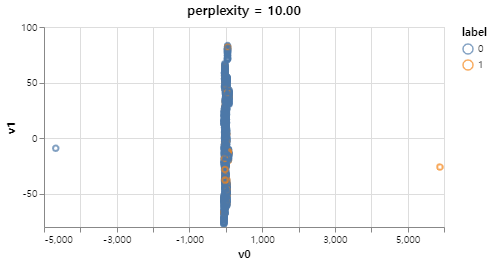

In [14]:
plots[0]

### SVM

In [15]:
from sklearn import svm

In [16]:
clf = svm.OneClassSVM(nu=0.05, kernel='rbf')
clf.fit(normal_scaled_X)

C:\Users\ARA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto_deprecated',
      kernel='rbf', max_iter=-1, nu=0.05, random_state=None,
      shrinking=True, tol=0.001, verbose=False)

In [17]:
y_pred = clf.predict(scaled_X)

In [18]:
y_pred = [1 if x == -1 else 0 for x in y_pred]

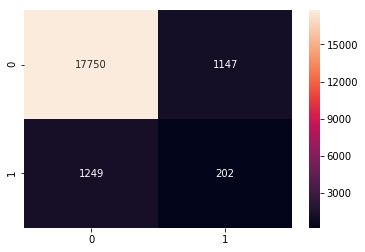

In [19]:
### plot confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

df_cm = pd.DataFrame(confusion_matrix(scaled_df['NG'].values.astype(int), y_pred))
sn.heatmap(df_cm, annot=True, fmt='d')

In [20]:
scaled_df['svm_label']= y_pred

### RandomFroest classifier

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(scaled_df[analy_col], scaled_df['NG'].values.astype(int), test_size=0.25, stratify=scaled_df['NG'].values.astype(int), random_state=123456)

In [22]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=True, random_state=123456, verbose=0,
            warm_start=False)

In [23]:
from sklearn.metrics import accuracy_score

predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)

print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Out-of-bag score estimate: 0.928
Mean accuracy score: 0.929


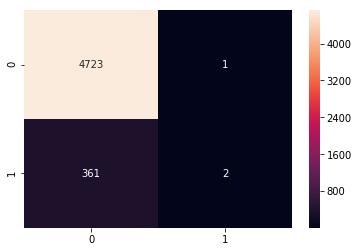

In [24]:
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(confusion_matrix(y_test, predicted))
sns.heatmap(cm, annot=True, fmt='g')

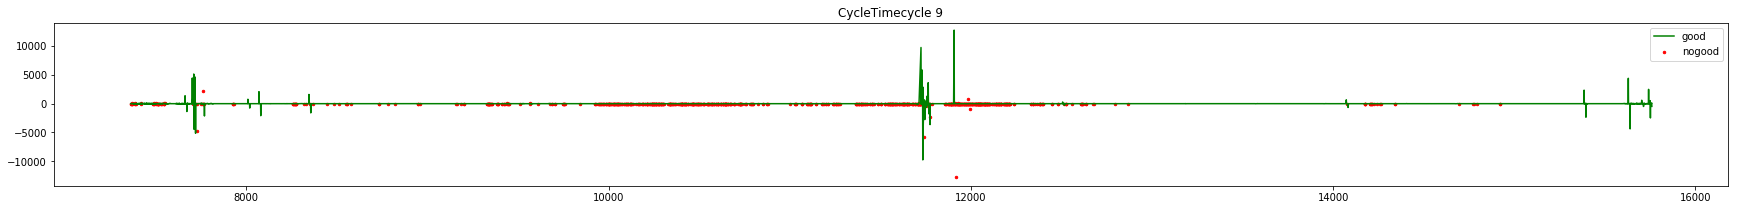

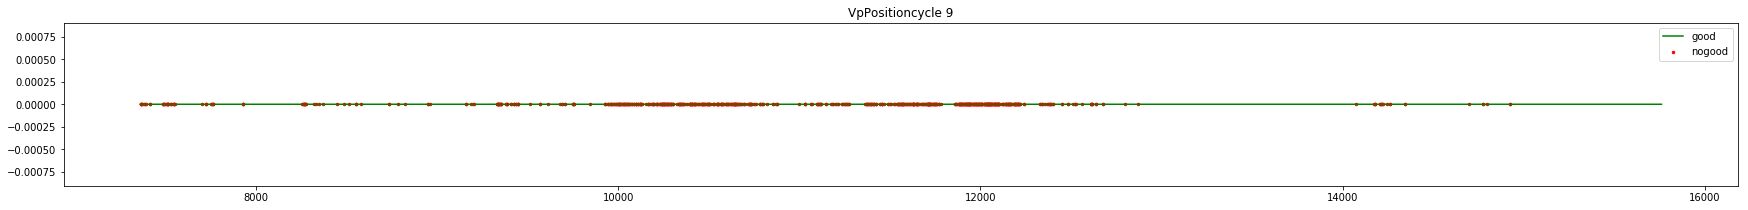

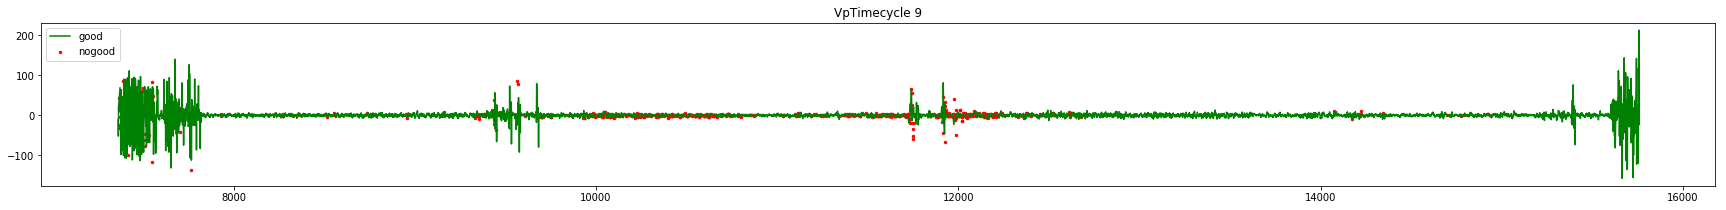

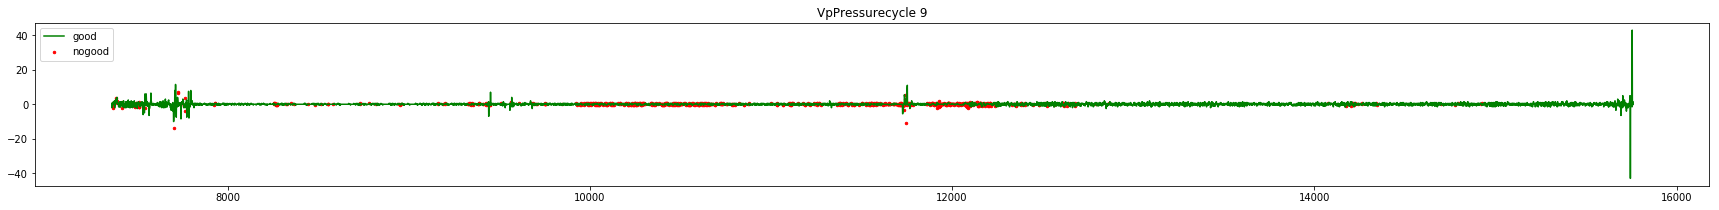

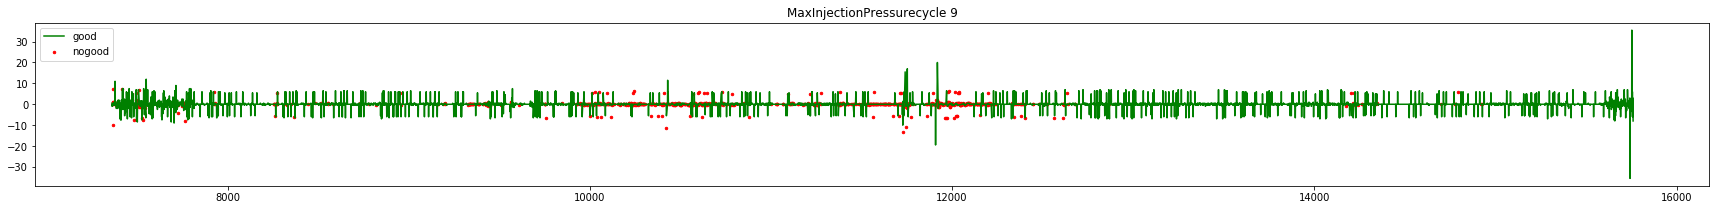

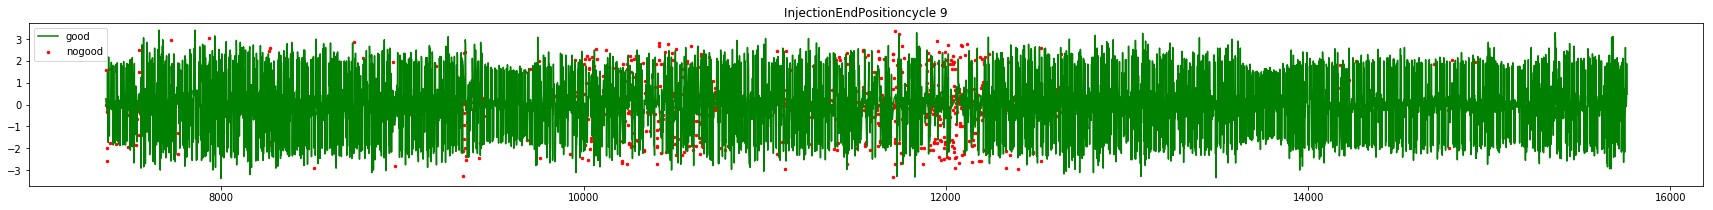

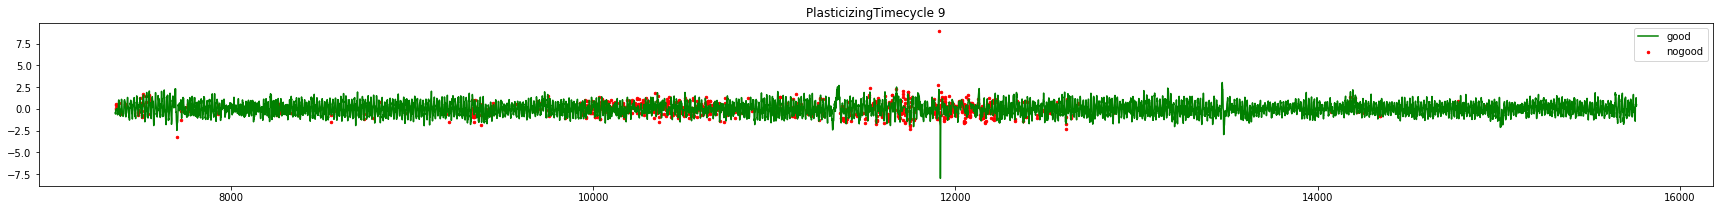

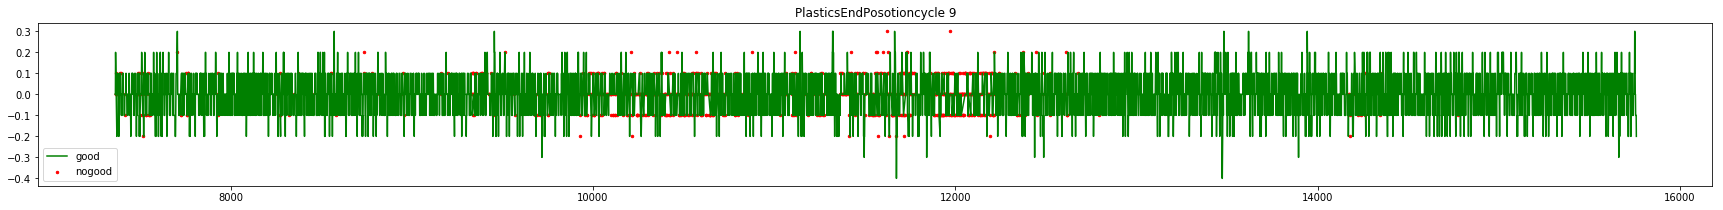

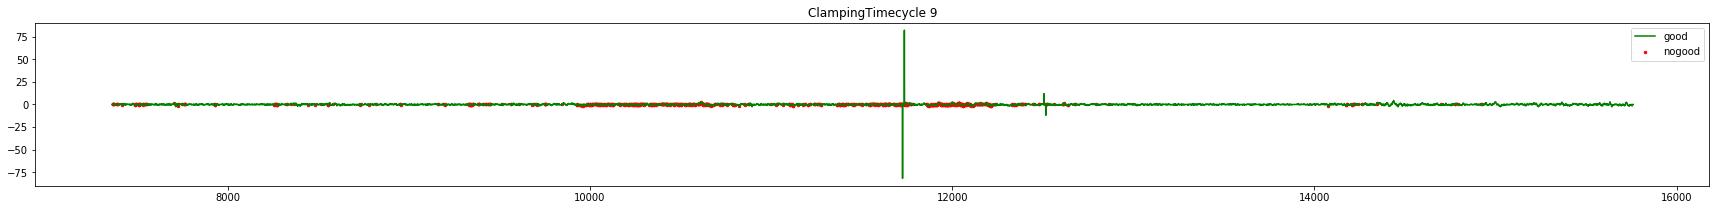

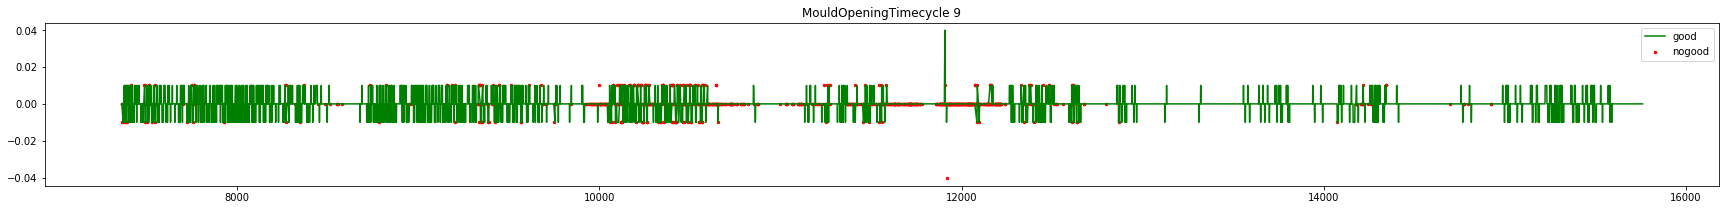

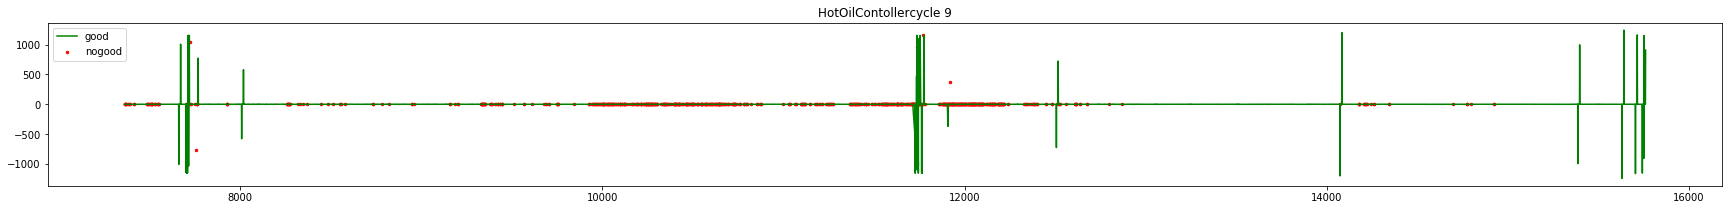

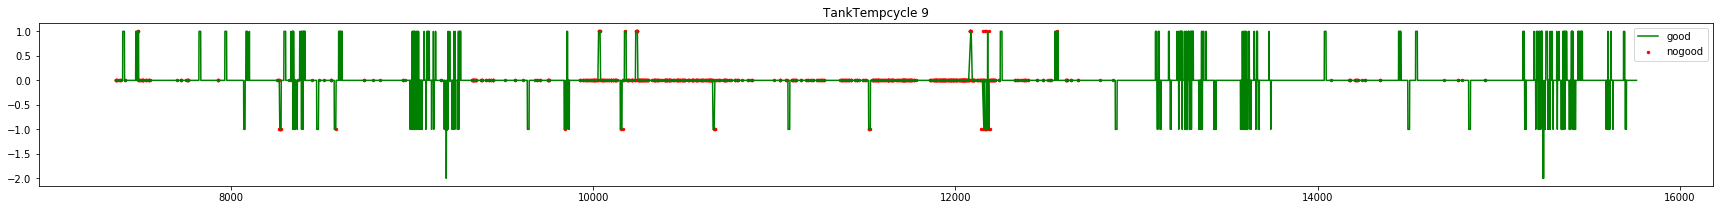

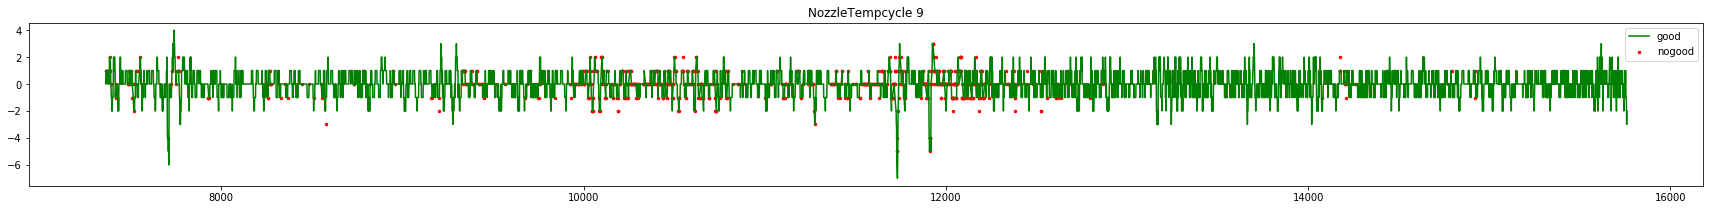

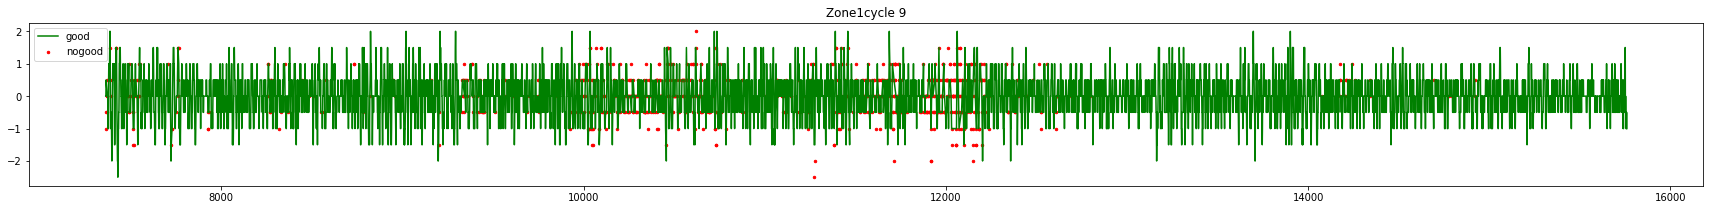

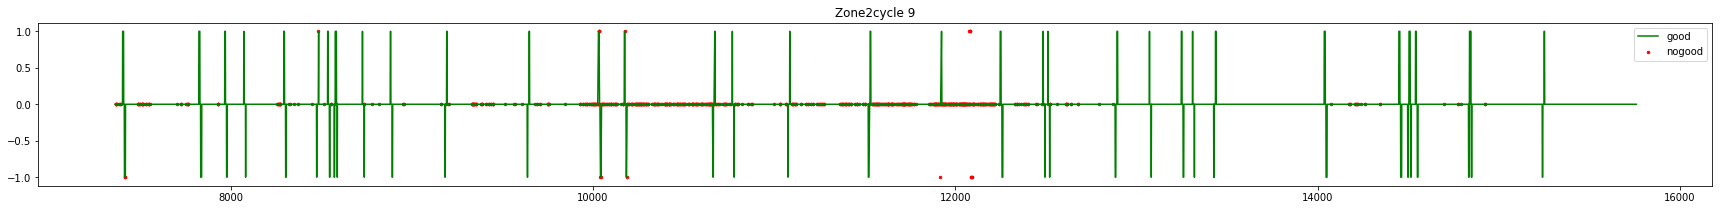

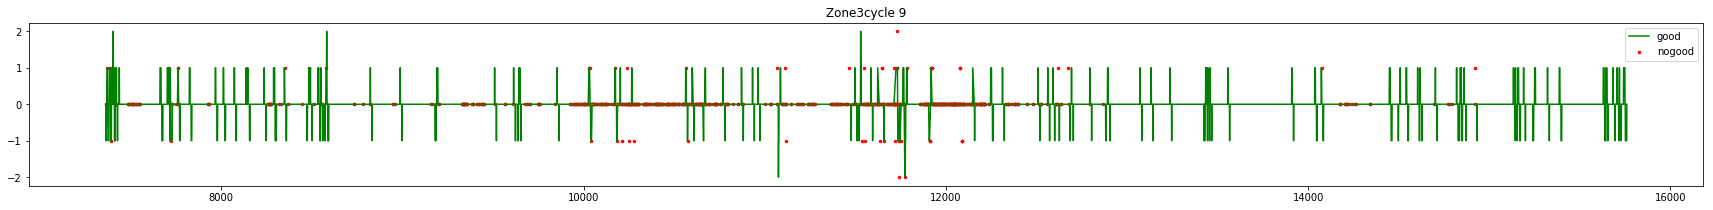

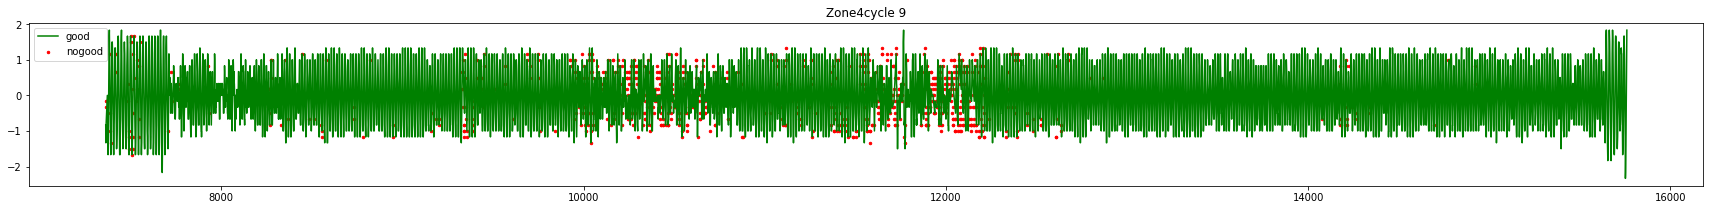

In [25]:
cycle_num = 9
df_name = scaled_df[scaled_df['CycleNum']==cycle_num]
col_list = analy_col
NG_target = 'NG'

for i in range(len(col_list)):
    fig, ax1 = plt.subplots(1,1, sharey=True, figsize=(30,3))
    ax1.plot(df_name[df_name[NG_target]==0][col_list[i]], color='g', label='good')
    ax1.scatter(df_name[df_name[NG_target]==1][col_list[i]].index, df_name[df_name[NG_target]==1][col_list[i]], color='r', label='nogood', s=6)
    ax1.legend()
    ax1.set_title(col_list[i]+'cycle '+ str(cycle_num))
    
#     ax2.plot(df9[df9['NG5']==0][col_list[i]], color='g', label='good')
#     ax2.scatter(df9[df9['NG5']==1][col_list[i]].index, df9[df9['NG5']==1][col_list[i]], color='r', label='nogood', s=6)
#     ax2.legend()
#     ax2.set_title(col_list[i]+'cycle 9')
    
#     ax3.plot(df11[df11['NG5']==0][col_list[i]], color='g', label='good')
#     ax3.scatter(df11[df11['NG5']==1][col_list[i]].index, df11[df11['NG5']==1][col_list[i]], color='r', label='nogood', s=6)
#     ax3.legend()
#     ax3.set_title(col_list[i]+'cycle 11')
    
#     ax4.plot(df69[df69['NG5']==0][col_list[i]], color='g', label='good')
#     ax4.scatter(df69[df69['NG5']==1][col_list[i]].index, df69[df69['NG5']==1][col_list[i]], color='r', label='nogood', s=6)
#     ax4.legend()
#     ax4.set_title(col_list[i]+'cycle 69')

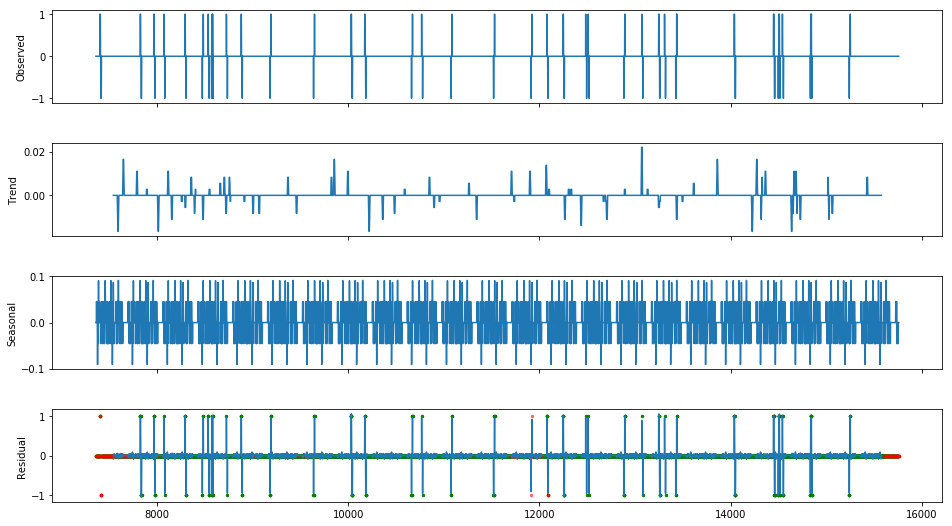

In [26]:
import statsmodels.api as sm
col = col_list[-3]

res = sm.tsa.seasonal_decompose(df_name[col].dropna(),freq=365)
fig = res.plot()
plt.scatter(df_name[df_name['svm_label']==0][col].index, df_name[df_name['svm_label']==0][col], color='g', label='good', s=6)
plt.scatter(df_name[df_name['svm_label']==1][col].index, df_name[df_name['svm_label']==1][col], color='r', label='bad', s=6, alpha=0.5)

fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

### GMM

In [27]:
from sklearn import mixture

In [28]:
g = mixture.GaussianMixture(n_components=2)

In [29]:
gmm = g.fit(normal_scaled_X) 

In [30]:
scaled_df['gmm_score']=gmm.score_samples(scaled_X)
scaled_df['gmm_label'] = [0 if x > -30 else 1 for x in scaled_df['gmm_score']]

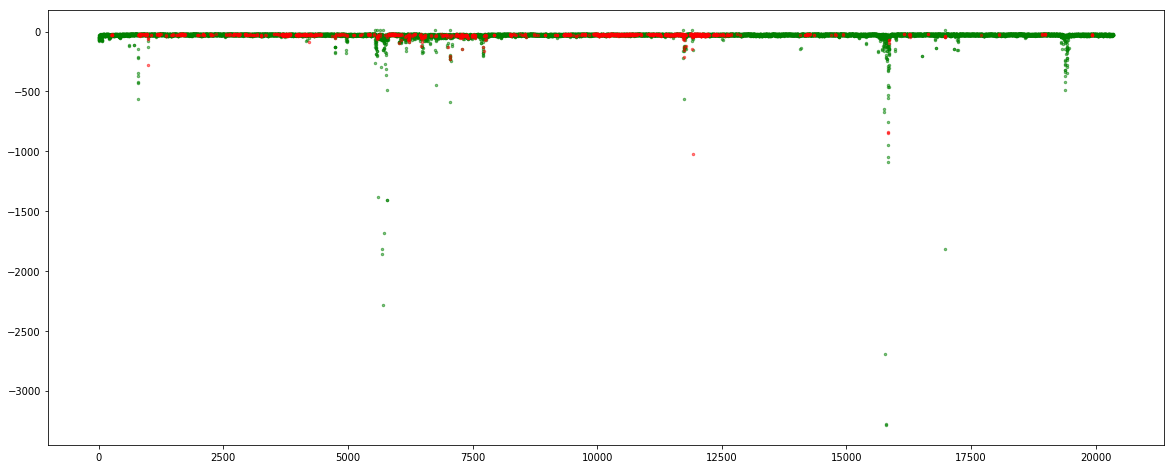

In [31]:
df = scaled_df
NG_target = 'NG'

plt.figure(figsize=(20,8))
plt.scatter(df[df[NG_target]==0]['gmm_score'].index, df[df[NG_target]==0]['gmm_score'], c='g', alpha=0.5, s=6)
plt.scatter(df[df[NG_target]==1]['gmm_score'].index, df[df[NG_target]==1]['gmm_score'], c='r', alpha=0.5, s=6)
#plt.scatter(df[df['NG_Label']==2]['gmm_score'].index, df[df['NG_Label']==2]['gmm_score'], c='r', alpha=0.5, s=6)

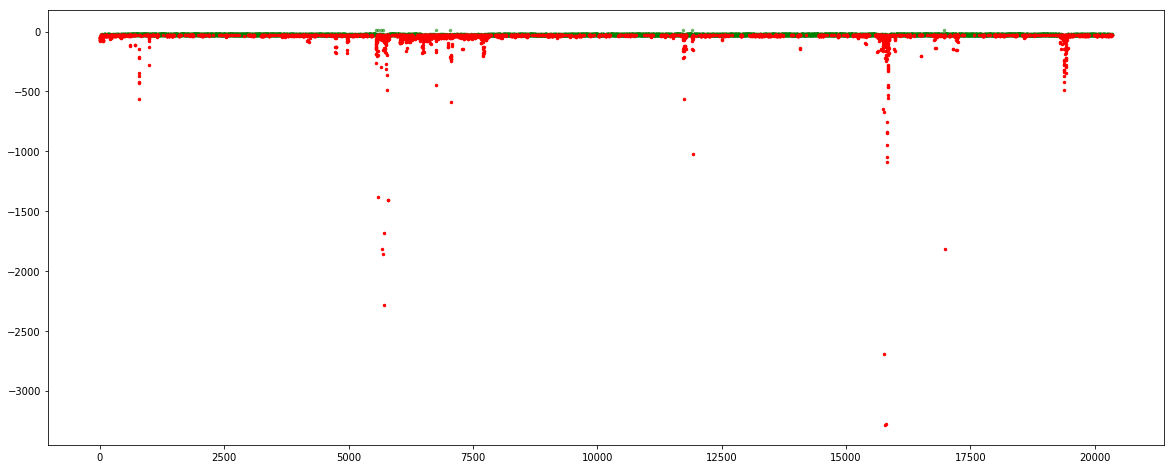

In [32]:
NG_target = 'gmm_label' #svm_label
plot_label = 'gmm_score'

plt.figure(figsize=(20,8))
plt.scatter(df[df[NG_target]==0][plot_label].index, df[df[NG_target]==0][plot_label], c='g', alpha=0.5, s=6)
plt.scatter(df[df[NG_target]==1][plot_label].index, df[df[NG_target]==1][plot_label], c='r', alpha=1, s=6)

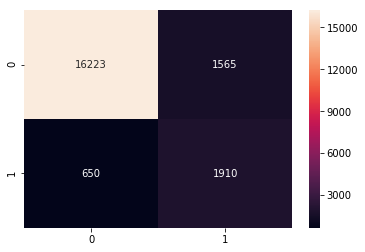

In [51]:
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(confusion_matrix(scaled_df['svm_label'], scaled_df['gmm_label']))
sns.heatmap(cm, annot=True, fmt='g')